In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from collections import Counter
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import NearMiss
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
df = pd.read_csv("heart.csv")
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0
4235,0,48,2.0,1,20.0,NaN,0,0,0,248.0,131.0,72.0,22.00,84.0,86.0,0
4236,0,44,1.0,1,15.0,0.0,0,0,0,210.0,126.5,87.0,19.16,86.0,NaN,0


In [ ]:
# df.isnull().sum()
print("Total null values", df.isnull().sum().sum())

Total null values 645


# ***Handling Missing Values***

In [ ]:
df['cigsPerDay'] = df['cigsPerDay'].fillna(df['cigsPerDay'].mode()[0])
df['education'] = df['education'].fillna(df['education'].median())
df['BPMeds'] = df['BPMeds'].fillna(df['BPMeds'].mode()[0])
df['totChol'] = df['totChol'].fillna(df['totChol'].median())
df['BMI'] = df['BMI'].fillna(df['BMI'].median())
df['heartRate'] = df['heartRate'].fillna(df['heartRate'].median())
df['glucose'] = df['glucose'].fillna(df['glucose'].median())

In [ ]:
df.isnull().sum()

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

# ***Handling Imbalanced Data***

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

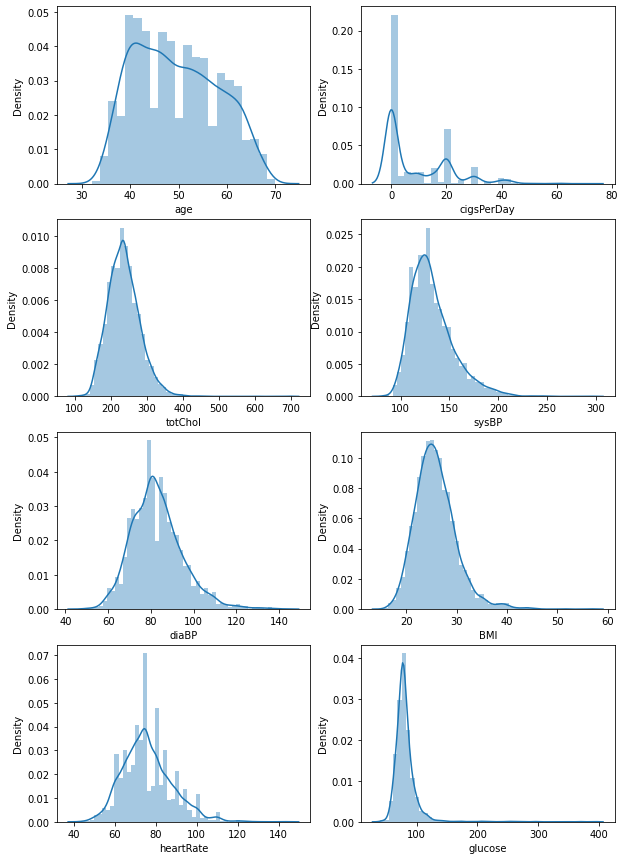

In [ ]:
columns = ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']

plt.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plt.subplot(4,2,plotnumber)
    sns.distplot(df[column])
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

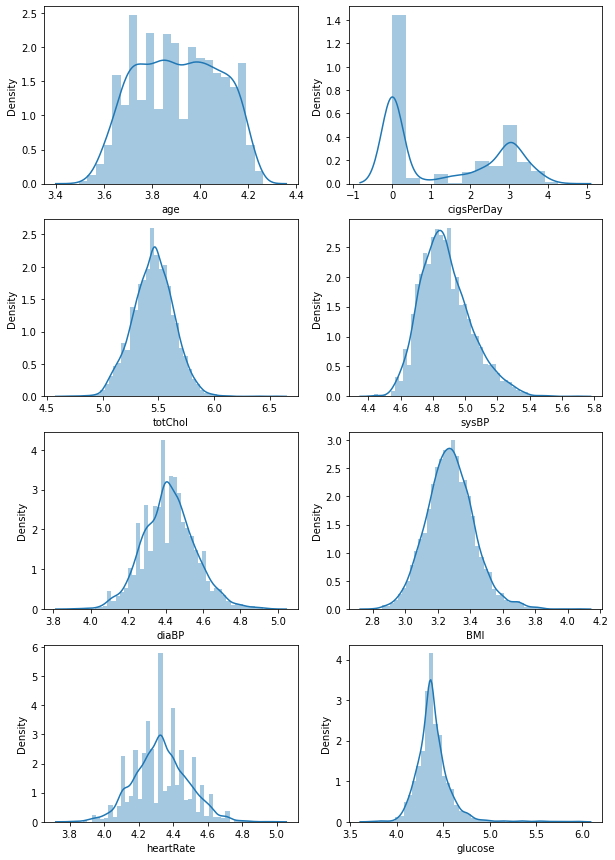

In [ ]:
columns = ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']

plt.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    df[column]+=1
    ax = plt.subplot(4,2,plotnumber)
    sns.distplot(np.log(df[column]))
    plt.xlabel(column,fontsize=10)
    plotnumber+=1
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


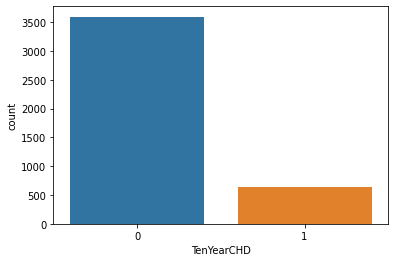

In [ ]:
sns.countplot(df['TenYearCHD'])

In [ ]:
X = df.drop(['TenYearCHD'],axis=1)
y = df['TenYearCHD']
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_resample(X,y)

In [ ]:
x_sampled.shape

(7188, 15)

In [ ]:
x_sampled = pd.DataFrame(data = x_sampled, columns = X.columns)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


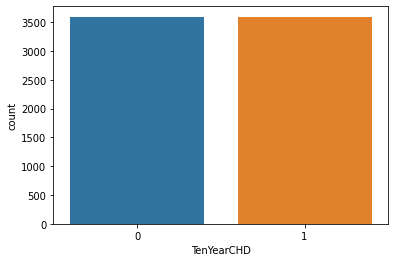

In [ ]:
sns.countplot(y_sampled)

In [ ]:
x_sampled.describe()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
count,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000,7188.000000
mean,0.474263,52.356706,1.935448,0.504035,10.689343,0.043823,0.009043,0.393294,0.041458,241.718559,138.088272,85.575125,27.121060,77.164719,85.463968
std,0.499372,8.598826,1.022500,0.500019,12.457219,0.204715,0.094670,0.488515,0.199361,46.542260,24.641640,12.992642,4.319333,12.143150,31.306022
min,0.000000,33.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,108.000000,84.500000,49.000000,16.540000,45.000000,41.000000
25%,0.000000,45.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,211.000000,121.000000,77.000000,24.240000,69.000000,73.000000
50%,0.000000,52.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,238.000000,133.000000,84.000000,26.690000,76.000000,79.000000
75%,1.000000,59.000000,3.000000,1.000000,21.000000,0.000000,0.000000,1.000000,0.000000,268.000000,151.000000,93.000000,29.350000,84.000000,88.000000
max,1.000000,71.000000,4.000000,1.000000,71.000000,1.000000,1.000000,1.000000,1.000000,697.000000,296.000000,143.500000,57.800000,144.000000,395.000000


In [ ]:
# res1 = pd.DataFrame(x_sampled)
# res1['TenYearCHD'] = y_sampled
# print(len(res))
# res1.to_csv("heart2.csv", index=False)

# Outlier

**cigsPerDay**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


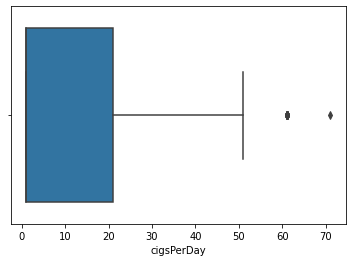

In [ ]:
# Box Plot
import seaborn as sns
sns.boxplot(x_sampled['cigsPerDay'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


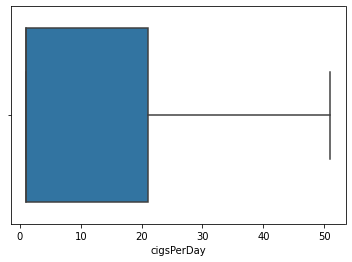

In [ ]:
for i in x_sampled['cigsPerDay']:
  q1=x_sampled['cigsPerDay'].quantile(0.25)
  q3=x_sampled['cigsPerDay'].quantile(0.75)
  iqr=q3-q1
  Lower_tail=q1-1.5*iqr
  Upper_tail=q3+1.5*iqr
  if i > Upper_tail or i < Lower_tail:
    x_sampled['cigsPerDay']=x_sampled['cigsPerDay'].replace(i,np.median(x_sampled['cigsPerDay']))
sns.boxplot(x_sampled['cigsPerDay'])
plt.show()

**totChol**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


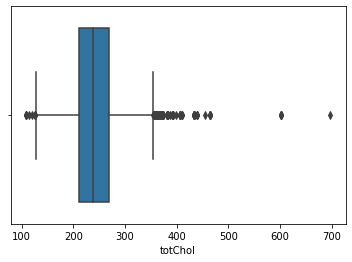

In [ ]:
# Box Plot
import seaborn as sns
sns.boxplot(x_sampled['totChol'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


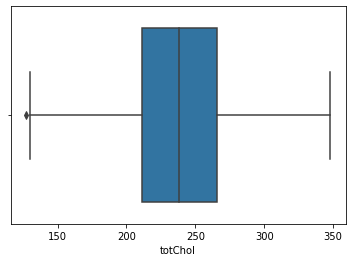

In [ ]:
for i in x_sampled['totChol']:
  q1=x_sampled['totChol'].quantile(0.25)
  q3=x_sampled['totChol'].quantile(0.75)
  iqr=q3-q1
  Lower_tail=q1-1.5*iqr
  Upper_tail=q3+1.5*iqr
  if i > Upper_tail or i < Lower_tail:
    x_sampled['totChol']=x_sampled['totChol'].replace(i,np.median(x_sampled['totChol']))
sns.boxplot(x_sampled['totChol'])
plt.show()

**BMI**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


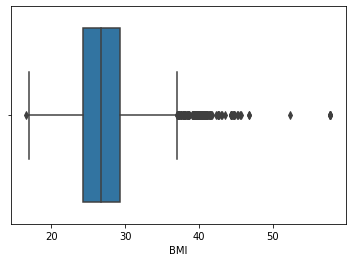

In [ ]:
# Box Plot
import seaborn as sns
sns.boxplot(x_sampled['BMI'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


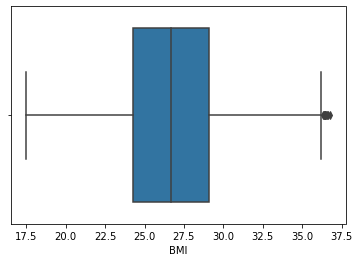

In [ ]:
for i in x_sampled['BMI']:
  q1=x_sampled['BMI'].quantile(0.25)
  q3=x_sampled['BMI'].quantile(0.75)
  iqr=q3-q1
  Lower_tail=q1-1.5*iqr
  Upper_tail=q3+1.5*iqr
  if i > Upper_tail or i < Lower_tail:
    x_sampled['BMI']=x_sampled['BMI'].replace(i,np.median(x_sampled['BMI']))
sns.boxplot(x_sampled['BMI'])
plt.show()

**Glucose**

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


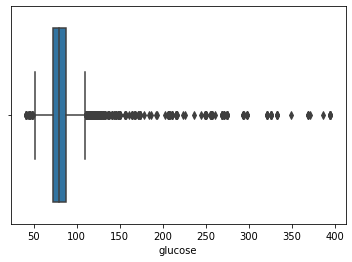

In [ ]:
# Box Plot
import seaborn as sns
sns.boxplot(x_sampled['glucose'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


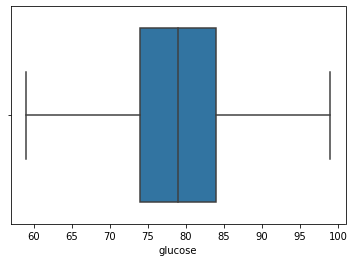

In [ ]:
for i in x_sampled['glucose']:
  q1=x_sampled['glucose'].quantile(0.25)
  q3=x_sampled['glucose'].quantile(0.75)
  iqr=q3-q1
  Lower_tail=q1-1.5*iqr
  Upper_tail=q3+1.5*iqr
  if i > Upper_tail or i < Lower_tail:
    x_sampled['glucose']=x_sampled['glucose'].replace(i,np.median(x_sampled['glucose']))
sns.boxplot(x_sampled['glucose'])
plt.show()

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    low_limit = quartile1 - 1.5 * interquartile_range
    up_limit = quartile3 + 1.5 * interquartile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in x_sampled.columns:
    print(col, check_outlier(x_sampled, col))

male False
age False
education False
currentSmoker False
cigsPerDay False
BPMeds True
prevalentStroke True
prevalentHyp False
diabetes True
totChol True
sysBP True
diaBP True
BMI True
heartRate True
glucose False


In [ ]:
# res = pd.DataFrame(x_sampled)
# res['TenYearCHD'] = y_sampled
# print(len(res))
# res.to_csv("heart3.csv", index=False)

7188
